# NLP21@BGU.CS - HW1

## Zvika Haramaty zvikah@post.bgu.ac.il
## Daniel Kuvachev (?) yourmail@...
### NLP 2021 - HW1 (http://www.cs.bgu.ac.il/~elhadad/nlp21/hw1.html)

Nov 2020

In [2]:
# Boring preliminaries
%pylab inline
import re
import math
import string
from collections import Counter
from __future__ import division

Populating the interactive namespace from numpy and matplotlib


<h2>Content</h2>

* <a href="#P1">Part 1: Language Models</a>
  * <a href="#data">1.1 Data Exploration</a>
    * <a href="#explore">1.1.1 Gathering basic statistics</a>
    * <a href="#power">1.1.2 Zipf and Power Law</a>
  * <a href="#ngram">1.2 n-gram model</a>
    * <a href="#n_parameters">1.2.1 How much memory do you expect a model to occupy?</a>
    * <a href="#train_lm">1.2.2 N-gram Word LM</a>
  * <a href="#eval">1.3 Language Model Evaluation</a>
    * <a href="#per">1.3.1 Perplexity</a>
    * <a href="#smoothing">1.3.2 Smoothing</a>
    * <a href="#overfit">1.3.3 Perplexity according to the order of the n-gram model
    * <a href="#test-lm">1.3.4 Test the best n-gram LM</a>
    * <a href="#gen">1.3.5 Generating Text using Language Models</a>
  * <a href="#nn-lm">1.4 Character language model</a>
    * <a href="#effectiveness">1.4.1 Read and Summarize</a>
    * <a href="#recipes">1.4.2 Recipes with a Character LM</a>
* <a href="#P2">Part 2: Polynomial curve fitting</a>
  * <a href="#syntheticdata">2.1 Synthetic data generation</a>
  * <a href="#curvefitting">2.2 Polynomial Curve Fitting</a>
  * <a href="#regularization">2.3 Polynomial Curve Fitting with Regularization</a>
  * <a href="#prob-regr">2.4 Probabilistic Regression Model</a>
* <a href="#P3">Part 3: Text Classification with Character RNN</a>
  * <a href="#readtut">3.1 Summarize the PyTorch Tutorial</a>
  * <a href="#newdata">3.2 Explore the Cities Dataset</a>
  * <a href="#citiesmodel">3.3 Train and Evaluate the RNN Model for Cities</a>
  * <a href="#bettercitiesmodel">3.4 (Optional) Improve the Model</a>

<hr>
<a name="P1"></a>
<h2>Part 1: Language Models</h2>

<a name="data"></a>
<h3>1.1 Data Exploration</h3>

<a name="explore"></a>
<h4>1.1.1 Gathering Basic Statistics</h4>

In this section, we collect and plot the following information on a text dataset:
<ul>
<li>The total number of tokens</li>
<li>The total number of characters</li>
<li>The total number of distinct words (vocabulary)</li>
<li>The total number of tokens corresponding to the top-N most frequent words in the vocabulary</li>
<li>The token/type ratio in the dataset</li>
<li>The number of types that appear in the dev data but not the training data</li>
<li>The average number and standard deviation of characters per token</li>
<li>The total number of distinct n-grams (of words) that appear in the dataset for n=2,3,4.</li>
<li>The total number of distint n-grams of characters that appear for n=2,3,4,5,6,7.</li>
</ul>

We operate on the PTB dataset, which contains 929k training words, 73k validation words, and 82k test words. 
It is formatted in such a way that only the top 10k most frequent words are in its vocabulary.

We gather the files from <a href="http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz">the dataset</a>
where sentences are segmented one per line and words separated by spaces.  We assume the files are located in "../data/".

#### Tokenizing

You may need to tokenize strings read from the dataset files into lists of tokens.  

Think which method is best appropriate for this dataset given the way it is formatting.
Recall the method based on regular expressions used in Norvig's piece.
Compare it with the the tokenizer provided in the nltk library.

In [3]:
import nltk
nltk.download('punkt')

text = "Won't this be tokenized, the way PTB expects it to be."
tokens = nltk.word_tokenize(text)
print(tokens)

print("We found %s tokens" % (len(tokens)))

['Wo', "n't", 'this', 'be', 'tokenized', ',', 'the', 'way', 'PTB', 'expects', 'it', 'to', 'be', '.']
We found 14 tokens


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The output of justext is organized in paragraphs.  We converted them as one line of text each.

Note how abbreviations in English are tokenized in PTB ("I'm" becomes ["I", "'m"]) and numbers are all replaced by the "N" special token.

we will now observe the ptb dataset , first we will load the train, validation and test words and tokenize them.
we know that this dataset have been preproccesed so there are only 10k most frequent words.
in the dataset there are 929k training words, 73k validation words and 82k test words.

In [4]:
import os

train_text = open(os.path.join(os.getcwd(), "..\data\ptb.train.txt")).read()
train_tokens = nltk.word_tokenize(train_text)
print("we found {num} tokens in train".format(num=len(train_tokens)))
print(train_tokens[:100])

we found 978754 tokens in train
['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec', 'ipo', 'kia', 'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens', 'sim', 'snack-food', 'ssangyong', 'swapo', 'wachter', 'pierre', '<', 'unk', '>', 'N', 'years', 'old', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', 'N', 'mr.', '<', 'unk', '>', 'is', 'chairman', 'of', '<', 'unk', '>', 'n.v.', 'the', 'dutch', 'publishing', 'group', 'rudolph', '<', 'unk', '>', 'N', 'years', 'old', 'and', 'former', 'chairman', 'of', 'consolidated', 'gold', 'fields', 'plc', 'was', 'named', 'a', 'nonexecutive', 'director', 'of', 'this', 'british', 'industrial', 'conglomerate', 'a', 'form', 'of', 'asbestos', 'once', 'used', 'to', 'make', 'kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high', 'percentage', 'of', 'cancer', 'deaths']


we can see that the word tokinizer isn't working as expected , we want the <unk> words to be marked as 1 token and not as 3 , we will use RegexTokinizer for that task

In [5]:
from nltk.tokenize import WhitespaceTokenizer

tokenizer = WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_text)
print(train_tokens[:100])
print("we found {num} tokens in train".format(num=len(train_tokens)))

['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec', 'ipo', 'kia', 'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens', 'sim', 'snack-food', 'ssangyong', 'swapo', 'wachter', 'pierre', '<unk>', 'N', 'years', 'old', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', 'N', 'mr.', '<unk>', 'is', 'chairman', 'of', '<unk>', 'n.v.', 'the', 'dutch', 'publishing', 'group', 'rudolph', '<unk>', 'N', 'years', 'old', 'and', 'former', 'chairman', 'of', 'consolidated', 'gold', 'fields', 'plc', 'was', 'named', 'a', 'nonexecutive', 'director', 'of', 'this', 'british', 'industrial', 'conglomerate', 'a', 'form', 'of', 'asbestos', 'once', 'used', 'to', 'make', 'kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high', 'percentage', 'of', 'cancer', 'deaths', 'among', 'a', 'group', 'of', 'workers', 'exposed', 'to', 'it']
we found 887521 tokens in train


we can see that the number of tokens is sagnifintcly smaller than before , abd we can see that we got reed of '<' , '>'.
we will use this method in the other datasets as well.

In [6]:
valid_text = open(os.path.join(os.getcwd(), "..\data\ptb.valid.txt")).read()
valid_tokens = tokenizer.tokenize(valid_text)
print(valid_tokens[:100])
print("we found {num} tokens in valid dataset".format(num=len(valid_tokens)))

test_text = open(os.path.join(os.getcwd(), "..\data\ptb.test.txt")).read()
test_tokens = tokenizer.tokenize(test_text)
print(test_tokens[:100])
print("we found {num} tokens in test dataset".format(num=len(test_tokens)))

['consumers', 'may', 'want', 'to', 'move', 'their', 'telephones', 'a', 'little', 'closer', 'to', 'the', 'tv', 'set', '<unk>', '<unk>', 'watching', 'abc', "'s", 'monday', 'night', 'football', 'can', 'now', 'vote', 'during', '<unk>', 'for', 'the', 'greatest', 'play', 'in', 'N', 'years', 'from', 'among', 'four', 'or', 'five', '<unk>', '<unk>', 'two', 'weeks', 'ago', 'viewers', 'of', 'several', 'nbc', '<unk>', 'consumer', 'segments', 'started', 'calling', 'a', 'N', 'number', 'for', 'advice', 'on', 'various', '<unk>', 'issues', 'and', 'the', 'new', 'syndicated', 'reality', 'show', 'hard', 'copy', 'records', 'viewers', "'", 'opinions', 'for', 'possible', 'airing', 'on', 'the', 'next', 'day', "'s", 'show', 'interactive', 'telephone', 'technology', 'has', 'taken', 'a', 'new', 'leap', 'in', '<unk>', 'and', 'television', 'programmers', 'are', 'racing', 'to', 'exploit']
we found 70390 tokens in valid dataset
['no', 'it', 'was', "n't", 'black', 'monday', 'but', 'while', 'the', 'new', 'york', 'stoc

we will now load the Shakespeare data set , we can see that this dataset was not preprocessed so we need to tokenize the words difrrently because we will also get spieciel chars as tokens(like '.').
we also expect this set to be smaller then our train dataset but this is not mendatory , somtimes test datasets are larger then the train ones.

In [7]:
shake_test_text = open(os.path.join(os.getcwd(), "..\data\shakespeare.txt")).read()
shake_test_tokens = tokenizer.tokenize(shake_test_text)
print("we found {num} tokens in shakesphere dataset".format(num=len(shake_test_tokens)))
print(shake_test_tokens[:100])

we found 832301 tokens in shakesphere dataset
['First', 'Citizen:', 'Before', 'we', 'proceed', 'any', 'further,', 'hear', 'me', 'speak.', 'All:', 'Speak,', 'speak.', 'First', 'Citizen:', 'You', 'are', 'all', 'resolved', 'rather', 'to', 'die', 'than', 'to', 'famish?', 'All:', 'Resolved.', 'resolved.', 'First', 'Citizen:', 'First,', 'you', 'know', 'Caius', 'Marcius', 'is', 'chief', 'enemy', 'to', 'the', 'people.', 'All:', 'We', "know't,", 'we', "know't.", 'First', 'Citizen:', 'Let', 'us', 'kill', 'him,', 'and', "we'll", 'have', 'corn', 'at', 'our', 'own', 'price.', "Is't", 'a', 'verdict?', 'All:', 'No', 'more', 'talking', "on't;", 'let', 'it', 'be', 'done:', 'away,', 'away!', 'Second', 'Citizen:', 'One', 'word,', 'good', 'citizens.', 'First', 'Citizen:', 'We', 'are', 'accounted', 'poor', 'citizens,', 'the', 'patricians', 'good.', 'What', 'authority', 'surfeits', 'on', 'would', 'relieve', 'us:', 'if', 'they', 'would']


we will now calculate the total number of chars in the ptb dataset , we expect the number of chars to be signifintly more than the number of words in each dataset, we expect that number to be bounded to biggest_word * number_of_words.

In [8]:
def split_words(words):
    chars = []
    for word in words:
        for char in word:
            chars.append(char)
    return chars

train_char_tokens = split_words(train_tokens)
print("we found {num} tokens".format(num=len(train_char_tokens)))

we found 4129961 tokens


In [9]:
shake_char_tokens = split_words(shake_test_tokens)
print("we found {num} tokens".format(num=len(shake_char_tokens)))

we found 3709942 tokens


we will know calculate the total number of disticnt words in the dataset, we know that the ptb dataset was preprocced so it will only containt the 10k most frequent words so that's what we expect to find there.
but in the shekspere dataset we didn't run such preprocess so we cant predict how much words are there in that data set but we can be sure it isn't larger then the entire dataset size which was 855k words.
in order to get the disticnt number of words we will just use the set object of python which provide uniquness to each word, and then we will check is size.

In [10]:
disticnt_words_train = set(train_tokens)
disticnt_words_valid = set(valid_tokens)
disticnt_words_test = set(test_tokens)
disticnt_words_shake = set(shake_test_tokens)

print("we found {num} words in the train".format(num=len(disticnt_words_train)))
print("we found {num} words in the valid".format(num=len(disticnt_words_valid)))
print("we found {num} words in the test".format(num=len(disticnt_words_test)))
print("we found {num} words in shakesphere dataset".format(num=len(disticnt_words_shake)))

we found 9999 words in the train
we found 6021 words in the valid
we found 6048 words in the test
we found 62983 words in shakesphere dataset


In [17]:
print('number of words which are diffrent in the train and valid {}'.format(len(disticnt_words_train.symmetric_difference(disticnt_words_valid))))
print('number of words which are diffrent in the train and test {}'.format(len(disticnt_words_train.symmetric_difference(disticnt_words_test))))
print('number of words which are diffrent in the train and shakesphere {}'.format(len(disticnt_words_train.symmetric_difference(disticnt_words_shake))))

number of words which are diffrent in the train and valid 3978
number of words which are diffrent in the train and test 3951
number of words which are diffrent in the train and shakesphere 64516


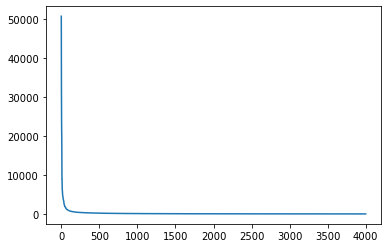

In [12]:
import collections
most_frequent_words = collections.Counter(train_tokens)
plt.plot([val for word,val in most_frequent_words.most_common(4000)])

In [13]:
average_tokens_per_type = sum([freq for freq in most_frequent_words.values()]) / len(most_frequent_words)
print('the average tokens per type in the dataset is {}'.format(average_tokens_per_type))

the average tokens per type in the dataset is 88.76097609760976


In [14]:
std_token_per_type = np.std([freq for freq in most_frequent_words.values()])
print('the std tokens per type in the dataset is {}'.format(std_token_per_type))

the std tokens per type in the dataset is 940.1980030300945


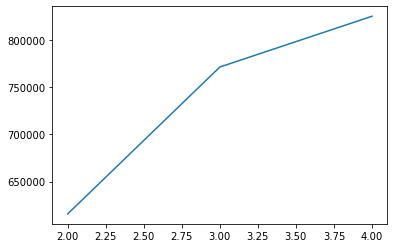

In [22]:
ngrams = []
for n in range(2,5):
    ngrams.append(len(set((tuple(train_tokens[i : i + n]), train_tokens[i + n]) for i in range(len(train_tokens) - n))))
plt.plot([i for i in range(2,5)], ngrams)

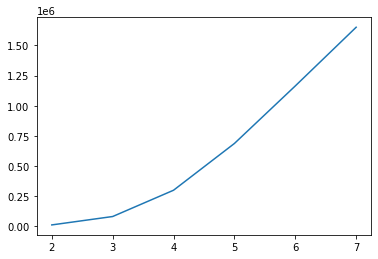

In [24]:
char_ngrams = []
for n in range(2,8):
    char_ngrams.append(len(set((tuple(train_char_tokens[i : i + n]), train_char_tokens[i + n]) for i in range(len(train_char_tokens) - n))))
plt.plot([i for i in range(2,8)], char_ngrams)

<a name="power"></a>
<h4>1.1.2 Zipf and Power Law</h4>

Word count distributions are said to follow <a href="https://en.wikipedia.org/wiki/Power_law">power law distributions</a>. 
In practice, this means that a plot of the log-frequency against the log-rank is nearly linear. 
We will verify that this holds for the Penn Treebank dataset by constructing the appropriate corpus_counts counter:


In [12]:
tokens = train_tokens
corpus_counts = Counter(tokens)

3.3.2


Text(0, 0.5, 'frequency')

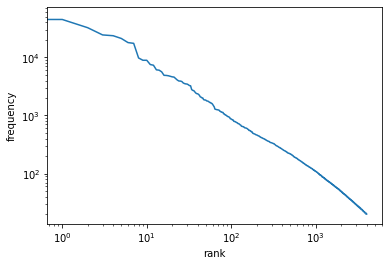

In [13]:
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__version__)

plt.loglog([val for word,val in corpus_counts.most_common(4000)])
plt.xlabel('rank')
plt.ylabel('frequency')

<a name="ngram"></a>
<h3><a name="ngram">1.2 n-gram Word Language Model</a></h3>

<a name="n_parameters"></a>
<h4>1.2.1 How much memory do you expect a model to occupy?</h4>

i think the model will occupy number_of_words ^ N , and since he have 10k words the model should oocupy 10K ^ N


<a name="train_lm"></a>
<h4>1.2.2 N-gram LM</h4>

We present a Python function to construct a word n-gram model given a dataset according to the signature:
<pre>
train_word_lm(dataset, n=2)
</pre>

we assume that the dataset was allready tokenized before

In [56]:
def add_padding(dataset, n=2):
    return ['*' for i in range(n)] + dataset

def prepare_dataset(dataset, n=2):
    dataset_with_padding  = add_padding(dataset, n)
    return [(tuple(dataset_with_padding[i : i + n]), dataset_with_padding[i + n]) for i in range(len(dataset_with_padding) - n)]

def create_lm(dataset, estimator=nltk.MLEProbDist, **kwargs):
    cfd = nltk.ConditionalFreqDist(dataset)
    return nltk.ConditionalProbDist(cfd, estimator, **kwargs)
    
def train_word_lm(dataset, n=2, estimator=nltk.MLEProbDist, **kwargs):
    word_grams = prepare_dataset(dataset, n)
    return create_lm(word_grams, estimator, **kwargs)

n = 2
lm = train_word_lm(train_tokens, n=n)
out = []
hist = ['*' for i in range(n)]
for _ in range(1000):
    word = lm[tuple(hist)].generate()
    hist = hist[1:]
    hist.append(word)
    out.append(word)
print(' '.join(out))

aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter pierre <unk> an <unk> the shift from socialism to capitalism he farms N acres in the litigation staff among the three carriers reach he said the market does recover the damage and no production slowdown is due to slowing sales of $ N billion yen us$ N million or N cents a share because the two disasters to nearly N N of <unk> men attempting a young boy now turned N on these grounds the budget deficit looms and the cia and fbi to immediately begin processing the japanese want us to define its monetary and fiscal policies germany 's enormous postwar prosperity and the nasd which operates the major nec competitors to ease <unk> rules <unk> gasb rules still apply for permission for bass to buy company shares at <unk> university in <unk> the nation sears said its <unk> calif. concern <unk> which are expected to result 

Provide:
* The list of methods of the object cpd that are useful for a language model (inherited or implemented by the various classes in nltk)
* Explain how the function generate() used in the sample works - why does it compute a correct way to sample from a distribution?


<a name="eval"></a>
<h3>1.3 Language Model Evaluation</h3>

We now evaluate the performance of the learned language models by using two techniques:
measuring perplexity on a validation dataset and using the model to generate random text, then assessing
the readability of the generated text.

<a name="per"></a>
<h4>1.3.1 Perplexity</h4>

We implement a Python function to measure the perplexity of a trained model on a test dataset.

In [15]:
# We adapt the methods to compute the cross-entropy and perplexity of a model from nltk.model
# to our implementation

def entropy(lm , n, text):
    e = 0.0
    probs = []
    counter = 0
    for i in range(len(text) - n):
        context = tuple(text[i : i + n])
        token = text[i + n]
        e -= lm[context].logprob(token)
    return e / float(len(text) - (n - 1))

def perplexity(lm, n, text):
    return pow(2.0, entropy(lm, n, text))


In [16]:
# We now measure the reported perplexity values on the Penn Treebank validation dataset ptb.valid.txt
vocabulary_size = len(set(train_tokens))
valid_tokens_with_padding = add_padding(valid_tokens)
print("results : {}".format(perplexity(lm, 2, valid_tokens_with_padding)))

43731


OverflowError: (34, 'Result too large')

Analyze the observed result...

we can observe that the result is to big because we encountered unseen words in the valid set $\lim_{x\to0^{+}} log(x)=-\infty$

<a name="smoothing"></a>
<h4>1.3.2 Smoothing</h4>

In order to improve the model, we will use a smoothing technique.

We use the <a href="http://www.nltk.org/_modules/nltk/probability.html">nltk probability distribution</a> module which provides different estimators that implement smoothing methods (Laplace, Lidstone, Witten-Bell, Good-Turing). 

In [ ]:
# We change the model to use a different estimator than the Maximum Likelihood Estimator (MLE) count-based estimator
# to compute the probability of p(w|history).  
laplace_lm = train_word_lm(train_tokens, n=2, estimator=nltk.LidstoneProbDist, bins=vocabulary_size, gamma=0.1)
valid_tokens_with_padding = add_padding(valid_tokens)
print("results : {}".format(perplexity(laplace_lm, 2, valid_tokens_with_padding)))

Compare the obtained perplexity of the trained model on the validation dataset for different Lidstone estimators for a 
variety of hyper-parameter gamma $0 \leq gamma \leq 1$ by drawing a graph of the obtained perplexity on the validation dataset for different values of gamma.


In [17]:
# Draw graph of perplexity of bigram LM for values of gamma with Lidstone estimator as smoothing method
perplexity_results = {}
max_iter = 10
valid_tokens_with_padding = add_padding(valid_tokens)
for i in range(1, max_iter + 1):
    gamma = i / max_iter
    laplace_lm = train_word_lm(train_tokens, n=2,  estimator=nltk.LidstoneProbDist, bins=vocabulary_size, gamma=gamma)
    perplexity_results[gamma] = perplexity(laplace_lm, 2, valid_tokens_with_padding)

0
0
0
0
0
0
0
0
0
0


{0.1: 2176.860464522929, 0.2: 2624.48852680885, 0.3: 2942.8820682716237, 0.4: 3194.8900907278576, 0.5: 3405.047880359019, 0.6: 3585.938001742114, 0.7: 3745.013279161242, 0.8: 3887.1073946166343, 0.9: 4015.55855154743, 1.0: 4132.781196996034}


Text(0, 0.5, 'perplexity')

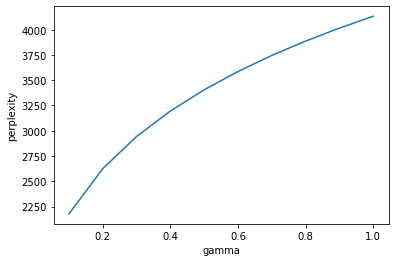

In [18]:
print(perplexity_results)
plt.plot(perplexity_results.keys(), perplexity_results.values())
plt.xlabel('gamma')
plt.ylabel('perplexity')

we can see that we get the best preplexity when gamma is the smallest , meaning we will use gamma = 0.1

<a name="overfit"></a>
<h4>1.3.3 Perplexity according to the order of the n-gram model</h4>

Another way to improve the model is to use an n-gram model with increasing values of n (2,3,...10).

In [19]:
# Draw a graph of the obtained perplexity on the validation dataset for different values of n between 2 and 20
# for the best value of gamma obtained above.
perplexity_results_n_gram = {}
max_iter = 10
gamma = 1
valid_tokens_with_padding = add_padding(valid_tokens)
for i in range(2, max_iter + 1):
    laplace_lm = train_word_lm(train_tokens, n=i, estimator=nltk.LidstoneProbDist, bins=vocabulary_size, gamma=0.1)
    perplexity_results_n_gram[i] = perplexity(laplace_lm, i, valid_tokens_with_padding)

0
0
0
0
0
0
0
0
0


{2: 2176.860464522929, 3: 5173.614758248297, 4: 7090.420590210644, 5: 8012.935911462408, 6: 8481.667891320034, 7: 8757.659397217209, 8: 8946.213476460991, 9: 9083.60772410707, 10: 9186.278663387231}


Text(0, 0.5, 'perplexity')

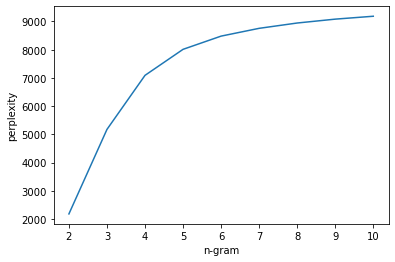

In [20]:
print(perplexity_results_n_gram)
plt.plot(perplexity_results_n_gram.keys(), perplexity_results_n_gram.values())
plt.xlabel('n-gram')
plt.ylabel('perplexity')

<a name="test-lm"></a>
<h4>1.3.4 Test the best n-gram LM</h4>

Based on the 2 graphs above, we hypothesize that the best combination LM is an n-gram of order NN smoothed with Lidstone estimator with parameter gamma = GG.

We test this model on the test dataset of the Penn Treebank and obtain the following perplexity on the validation set:

In [21]:
## Test LM with optimal parameters - report perplexity on validation.
laplace_lm = train_word_lm(train_tokens, n=2,  estimator=nltk.LidstoneProbDist, bins=vocabulary_size, gamma=0.1)
test_tokens_with_padding = add_padding(test_tokens)
print('perplexity on the test set {}'.format(perplexity(laplace_lm, 2, test_tokens_with_padding)))

0
perplexity on the test set 2197.8393203748356


We also test our n-gram model with the <a href="https://www.nltk.org/api/nltk.html#nltk.probability.SimpleGoodTuringProbDist">Good-Turing estimator instead of the Lidstone estimator.

In [22]:
## Test LM with Good-Turing estimator - report perplexity.
simple_good_turing_lm = train_word_lm(train_tokens, n=2, estimator=nltk.SimpleGoodTuringProbDist, bins=vocabulary_size)
test_tokens_with_padding = add_padding(train_tokens)
print('perplexity on the test set {}'.format(perplexity(simple_good_turing_lm, 2, test_tokens_with_padding)))

C:\Users\Dani\miniconda3\envs\nlp21\lib\site-packages\nltk\probability.py:1456: UserWarning: SimpleGoodTuring did not find a proper best fit line for smoothing probabilities of occurrences. The probability estimates are likely to be unreliable.
  warnings.warn(


341988


OverflowError: (34, 'Result too large')

To assess the success of these LMs, we compare our result with a set of baselines:
* the expected results on a uniform distribution of words (worst case) 
* recent research results reported in research paper on language models that you can find in Google Scholar tested on the Penn Treebank dataset.

<a name="gen"></a>
<h4>1.3.5 Generating Text from a Language Model</h4>

Another way to evaluate a language model is to use the model in a generative manner - that is, to randomly sample
sentences starting from a seed prefix, and generating each next word by sampling from the model distribution $p(w | prefix)$.

Discuss ways to decide when the generation should stop.

In [ ]:
# Define generate(model, seed) 

# Test generate it on the best model trained above

def generate(model, seed, n):
    seed_with_padding = add_padding(seed, n)
    new_word = model[seed_with_padding].generate()

When we sample from the LM given a history, we do not pick the most likely word generated by the LM, otherwise the generator would be deterministic.  Instead, we use <a href="https://www.nltk.org/api/nltk.html#nltk.probability.ProbDistI.generate">nltk.ProbDistI.generate()</a>.  
* Explain what is expected from this method of text generation.

We experiment with a variety of seeds.  

We first test the case where ....

Then the case where ....

Analyze your observations.

<h4>Optional material</h4>

One way to control the variety of the text generated by an LM is to introduce a parameter called the <i>temperature</i>
of the generator which allows us to sample words randomly according to the distribution produced by the LM (that is, we do not 
always select the most likely candidate - we sample from the distribution produced by the LM).  
    
<a href="https://nlp.stanford.edu/blog/maximum-likelihood-decoding-with-rnns-the-good-the-bad-and-the-ugly/">Maximum Likelihood Decoding with RNNs - the good, the bad, and the ugly</a> by Russell Stewart (2016) explains how a temperature argument can control the level of variability generated by the model.  

The idea is ... (summarize the post).

<a href="https://github.com/sameersingh/uci-statnlp/blob/master/hw2/generator.py">generator.py</a> from Sameer Sing demonstrates a method to generate from a LM with a temperature parameter.  

Explain how the code in this method corresponds to the mathematical explanation provided in the blog above.

<a name="nn-lm"></a>
<h3>1.4 Character language model</h3>

It is interesting to compare word-based and character-based language models.
On the one hand, character-based models need to predict a much smaller range of options (one character out of ~100 possible characters vs. one word out of 200K possible words - or 10K in the example we reviewed above).  
On the other hand, we need to maintain a much longer history of characters to obtain a significant memory of the context which would make sense semantically.


<a name="effectiveness"></a>
<h4>1.4.1 Read and Summarize</h4>

<h5>1.4.1.1 <a href="http://karpathy.github.io/2015/05/21/rnn-effectiveness/">The Unreasonable Effectiveness of Recurrent Neural Networks</a>, May 21, 2015, Andrej Karpathy </h5>

The article’s author claims that RNNs have surprising power for NLP tasks – acting as character level language model.

The uniqueness of RNNs over other neural networks is because they work on sequences of inputs – if we think of RNN as a function, the result of the function is not dependent only on the current input, but on all previous inputs. Therefore, they have more power over regular LMs, which are based on N-grams, with a fixed amount of previous word taken into account (while RNNs can take all history into account).

Since the author used RNNs as LMs, he can generate words, from given history. That’s way he generated not only words, but whole articles, in different styles, and even almost-perfect structured text, like LaTeX and even “Linux” source code.

We know that according to Chomsky's hierarchy of languages the most expressive languages are recursively enumerable languages, which can be modeled by a Turing Machine. RNNs have only finite memory, therefore, they can be thought of them as FSMs, capable of handling only regular languages. Thus, it’s quite surprising that RNNs can “know” arbitrary languages.

It’s interesting that the author of the article is working on character level; while according to what we’ve learnt we would have expected better results with word based RNNs. He briefly mentions that “Currently it seems that word-level models work better than character-level models, but this is surely a temporary thing.” We don’t understand this claim, and we are not sure that it proved itself to be true.


<h5>1.4.1.1 The follow-up article: The unreasonable effectiveness of Character-level Language Models (and why RNNs are still cool) </h5>
<a href="http://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139">The unreasonable effectiveness of Character-level Language Models (and why RNNs are still cool)</a>, Sept 2015, Yoav Goldberg.  

In this article Goldberg claims that there’s actually nothing special about most of the results shown by the “The Unreasonable Effectiveness of Recurrent Neural Networks” article. The generative power of traditional n-grams based LMs, with order of no more than 10, is already impressing, and generates nice and readable texts. The RNNs aren’t worse; but neither are they better in that aspect. Thus, “The Unreasonable Effectiveness of Recurrent Neural Networks” examples of Paul Graham’s style texts, or Shakespearean style text, have nothing really new in them, and Goldberg demonstrates his own “new” Shakespearean text.

However, the thing that is really impressing about RNNs isn’t their mere power of generating text, but their power of generating structured text, such as the Linux code example. When he tried to generate similar code with LMs, it miserably failed with order of 10 (that was good enough to create “a new Shakespeare text”) , and even with order of 20, it created better results, but still failed with things like indentation and brackets – which RNNs done pretty much OK. That’s the point where RNNs “memory” gave much better results than the LMs “short memory”. Thus, in structured text RNNs excels and indeed worthy the “Unreasonable Effectiveness” title.


<a name="recipes"></a>
<h4>1.4.2 Recipes with a Character LM</h4>

Strikingly realistic output can be generated when training a character language-model on a strongly-constrained genre of text like cooking recipes.
Train your n-gram model on the dataset provided in 
<a href="https://gist.github.com/nylki/1efbaa36635956d35bcc">do androids dream of cooking?</a> which contains about 32K recipes gathered from the Internet.

Gather the recipes dataset and prepare a dataset reader according to the structure of the files.

In [26]:
dataset = []
for (dirpath, dirnames, filenames) in os.walk('../data/recipes_dataset'):
    for file in filenames:
        with open(os.path.join('../data/recipes_dataset', file), encoding='utf-8', errors='ignore') as file:
            dataset.append(file.read())
print(dataset[0][:1685])

MMMMM----- Recipe via Meal-Master (tm) v8.05
 
      Title: "BE MINE" LOLLIPOPS
 Categories: Candies, Valentine
      Yield: 8 Servings
 
           Text only
 
  Source: Better Homes and Gardens, Febuary 1998 Prep time: 20 minutes
  Cook: 6 to 8 minutes
  
  2 1/2 to 3 1/2-inch round or heart-shaped metal cookie cutters 8 oz.
  assorted red, pink, and/or clearhard candies 35 to 60 (2 to 3 oz.)
  assorted small decorative candies, such as red cinnamon candies,
  small nonpareils, colored candy hearts, spice drops, and gumdrops
  Edible rose petals or other flower petals (optional) Lollipop sticks
  
  Place unwrapped hard candies in a heavy plastic bag, then place bag
  on top of folded towel and crush candies into small chunks wiht meat
  mallet or small hammer.
  
  Make only three or four lollipops at one time.  Line a baking sheet
  with foil.  Place desired cookie cutters on foil, at least 2 inches
  apart. Divide crushed candies evenly among cutters, approximately 1
  1/2 to 2 ta

we can see that a recipe starts with MMMMM---- and ends with MMMMM , we need to construct an expression which captures this pattern

In [27]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer('MMMMM-----.*?MMMMM$')
recipies = []
for recipe in dataset:
    recipies.extend(tokenizer.tokenize(recipe))
print(recipies[0])

MMMMM----- Recipe via Meal-Master (tm) v8.05
 
      Title: "BE MINE" LOLLIPOPS
 Categories: Candies, Valentine
      Yield: 8 Servings
 
           Text only
 
  Source: Better Homes and Gardens, Febuary 1998 Prep time: 20 minutes
  Cook: 6 to 8 minutes
  
  2 1/2 to 3 1/2-inch round or heart-shaped metal cookie cutters 8 oz.
  assorted red, pink, and/or clearhard candies 35 to 60 (2 to 3 oz.)
  assorted small decorative candies, such as red cinnamon candies,
  small nonpareils, colored candy hearts, spice drops, and gumdrops
  Edible rose petals or other flower petals (optional) Lollipop sticks
  
  Place unwrapped hard candies in a heavy plastic bag, then place bag
  on top of folded towel and crush candies into small chunks wiht meat
  mallet or small hammer.
  
  Make only three or four lollipops at one time.  Line a baking sheet
  with foil.  Place desired cookie cutters on foil, at least 2 inches
  apart. Divide crushed candies evenly among cutters, approximately 1
  1/2 to 2 ta

Report basic statistics about the dataset (number of recipes, tokens, characters, vocabulary size, distribution of the size of recipes in words and in chars, distribution of length of words).

In [39]:
print('number of recipes is the data set : {}'.format(len(recipies)))
tokenized_recipies = []
for recipe in recipies:
    tokenized_recipies.append(WhitespaceTokenizer().tokenize(recipe))
number_of_tokens = sum([len(recipe) for recipe in tokenized_recipies])
print('number of tokens in the dataset : {}'.format(number_of_tokens))

number of recipes is the data set : 32963
number of tokens in the dataset : 5852065


In [29]:
vocabulary_size = len(set([y for x in tokenized_recipies for y in x]))
print(vocabulary_size)

150949


we can see that we got a huge number, and that is beacuse we didnt do any preprocessing to dataset, in order to currectly measure the vocabulary size , we need to remove numbers and special chars and also lower the strings so there wont be any diffrence between the and The.

In [30]:
import re
lower_recipies = [y.lower() for x in tokenized_recipies for y in x]
without_special_char = set([re.sub('[^A-Za-z]+', '', string) for recipe in tokenized_recipies for string in recipe])
vocabulary_size = len(without_special_char)
print(vocabulary_size)

78956


In [31]:
number_of_chars = set(x for recipe in tokenized_recipies for string in recipe for x in string)
print(len(number_of_chars))

99


In [33]:
average_words_in_recipe = sum([len(recipe) for recipe in tokenized_recipies]) / len(tokenized_recipies)
print(average_words_in_recipe)
std_words_in_recipe = np.std([len(recipe) for recipe in tokenized_recipies])
print(std_words_in_recipe)

177.53435670297
95.63421891115212


In [37]:
average_chars_in_recipe = sum([len(word) for recipe in tokenized_recipies for word in recipe]) / len(tokenized_recipies)
print(average_chars_in_recipe)
std_chars_in_recipe = np.std([sum([len(word) for word in recipe]) for recipe in tokenized_recipies])
print(std_chars_in_recipe)

849.9724843005795
449.01228751877915


In [44]:
average_length_of_words_in_recipe = sum([len(word) for recipe in tokenized_recipies for word in recipe]) / number_of_tokens
print(average_length_of_words_in_recipe)
std_length_of_words_in_recipe = np.std([len(word) for recipe in tokenized_recipies for word in recipe])
print(std_length_of_words_in_recipe)

4.787650683989327
3.220266831664587


Split the dataset into training, dev and test as a 80%/10%/10% split.  Provide a Python interface to access the split conveniently.

In [101]:
def split_dataset(dataset):
    random.shuffle(dataset)
    train_size = math.ceil(0.8 * len(dataset))
    valid_size = math.ceil(0.1 * len(dataset)) + train_size
    train = dataset[:train_size]
    valid = dataset[train_size: valid_size]
    test = dataset[valid_size:]
    return train, valid, test

train, valid, test = split_dataset(recipies)
print(train[0])

MMMMM----- Recipe via Meal-Master (tm) v8.05
 
      Title: CHERRY NUT BREAD
 Categories: Breads
      Yield: 6 Servings
 
      1 c  Brown sugar
    1/4 c  Margarine
      1 ea Egg
      2 c  Flour
      2 ts Baking powder
      1 ts Salt
      1 cn Dalton cherries small jar
    1/2 c  Walnuts
 
  cream sugar & margarine. add egg, sift flour baking powder and salt.
  In cup put juice of cherries and fill cup with milk. Add milk mixture
  alternately with flour adding cut up cherries & nuts with each
  portion of flour. Bake in 350 F oven in loaf pan 1 hour or until
  toothpick comes out clean.
 
MMMMM


Choose the order of the char n-gram according to the indications given in Yoav Goldberg's article.  
Justify the choice (you should use the dev test for this).

from yoav goldberg's article i learned that we need to choose n which is larger then 4 but there isn't really a formula of chosing it , we try and if it doesn't work than we increase n to somthing larger

Train a char language model using your LM mode adapted to work on characters instead of words.

we will start with n = 4 , lets see the generated result. one importent detail is after some trail and error i found out that i get the best result if i use padding on each recipe, by that the model seems to learn some kind of structure of the recipe.

In [113]:
def combine_recipies(dataset):
    return [char for recipe in dataset for char in recipe]

def tokenize_recipe(recipe):
    return [char for char in recipe]

def prepare_recipe_dataset(dataset, n):
    dataset_with_padding = []
    for recipe in dataset:
        dataset_with_padding.append(add_padding(tokenize_recipe(recipe), n))
    combined_recipies = combine_recipies(dataset_with_padding)
    return [(tuple(combined_recipies[i : i + n]), combined_recipies[i + n]) for i in range(len(combined_recipies) - n)]

def train_char_lm(dataset, n, estimator=nltk.MLEProbDist, **kwargs):
    char_grams = prepare_recipe_dataset(dataset, n)
    return create_lm(char_grams, estimator, **kwargs)
    
def generate_samples(lm, n, letters):
    hist = ['*' for i in range(n)]
    out = []
    for _ in range(letters):
        word = lm[tuple(hist)].generate()
        hist = hist[1:]
        hist.append(word)
        out.append(word)
    return ''.join(out)

n = 4
lm = train_char_lm(train, n=n)
print(generate_samples(lm, n, 2000))

MMMMM****MMMM****MMMMMM****MMMMMM****MMMM----- Recipe By        -Kyllis with onion.  To seconomics or until first
  board. Set in a microwave
 
MMMM*****MMMM****MMMM---- Recipe via Meal-Master or a steamed milk mixture diced
    1 1/2 tb Fine inse wafers and set aside. 3. Bring soda and
     3/4 c  Butter and let simmer and leek. Poultry brown.  Add
  mixtures
    1 lb Butter
 
  *Do not red --
    3    Beated and Tabasco
    Eggs
 
  TO MAKER QUICK BEANS (HERS
 Categories: Frients; simmedium-high heat to 5 minutes. Set aside.  Stir until in plate chips over
      Yield: 4 Serve wings
 
  Frosting Mix, 3 greast; grill 1 jalapeno pepper; scallis@oxygen.aps1.anl.gov (Danis)
    Eggs; half in a wool.
  :    1 ea Greasts with remaining outer (tm) v8.05
 
  At lost curls once.
  
  Potatoes evaporates on fold table oil
      3 times.
  
  1 barbecue wheat oil. Cut and simmer and stick into 2 x  Caraway for spoon on
     Yield: 1 ts Vanilla,
  pull Puree all dry packen spoon baked. Sticking 

it's readable but still doesn't look good, the structure is all wrong , lets try n = 7:

In [117]:
n = 7
lm_7 = train_char_lm(train, n=n)
print(generate_samples(lm_7, n, 2000))

*MMMMM----- Recipes. 3 working in each side,then dump couscous with sliced
 
  In a medium heat,
  onion until smooth batter into gelatin completelyon a rack to a large stock,
  smooth and bake for 15 minutes. Add a little lemon juice
      Title: CRAIG CLAIBORNE'S NOTE:  I used to individual casserole:
  
  From:
 
MMMMM********MMMMM----- Recipe via Meal-Master (tm) v8.05
 
    1/4 ts Pepper
      2 ts Cornstarch
      Yield: 4 Servings
 
MMMMM----- Recipe via Meal-Master (tm) v8.05
 
            Fresh mint sprigs, if desired. 12 Pour batter
           or spreading whatever is very delicious)
            -trussing nutmeg and mix well. In
  small jar with crab meat with nutmeg
      1 pk Puff pastry browned and cheese, soften, until
  light and diced Ham -- thinly
      1 c  Whipped cream
  and water, if
  desired.
  
  Country Magazine, July, Ovo lacto
      Title: DUNDEE CAKE (GELB KUCHEN
 Categories: Vegetarian, Sauces, Pasta
                                      Layer them with 3
 

this one looks alot better then the previos one but we still get some syntax errors, lets try n=10:

In [118]:
n = 10
lm_10 = train_char_lm(train, n=n)
print(generate_samples(lm_10, n, 2000))

MMMMM----- Recipe via Meal-Master (tm) v8.05
 
      Title: ASPARAGUS SALAD WITH FENNEL & ORANGE SALAD
 Categories: Ice cream
  scoop to fill mold 3/4 full.
  
  Beans and tomato cut in pieces in
  about 35 minutes
  
  Place artichoke
    1/4 c  Butter, softened
          Cayenne pepper
  
  Score the surface, roll out to 18- x 6-inch rectangles. Place
  the eggnog base is done but not brown. Remove from heat and starting with something else you
  carve it. Using a pastry blender, place the margarine; melted
 
  In a small bowl, combine 1/4 teaspoon of mixture a little
  more flour and add half to eggs; beat for 2 minutes. Turn
  the peppers and roll in butter, salt, and pepper to taste
      1 lb Ham, cubed
      1 tb Baking powder
  1 1/4 c  Water, room temperature. Makes 3 cups. Courtesy of Bon
  Appetit
  
  From the files of Al
  Rice, North Pole Alaska.    Feb 1994
 
MMMMM**********MMMMM---------------------------------------------------

MMMMM----- Recipe via Meal-Master (tm) v

we can see that the best result is with n=10, the stracture looks good and readable.

Report on the perplexity of the trained language model.  Comment on the value you observe compared to the perplexity of the word LM model obtained above.

In [120]:
valid_dataset = prepare_recipe_dataset(valid, 10)
print('perplexity with n=7 is {}'.format(perplexity(lm_10, 10, valid_dataset)))

3861070


OverflowError: (34, 'Result too large')

we can see that we got bad results because we didn't use smoothing, we will use lidstone estimator now.

In [32]:
n = 10
lm_10 = train_char_lm(train, n=n, estimator=nltk.LidstoneProbDist, bins=99, gamma=0.1)
print(generate_samples(lm_10, n, 2000))

NameError: name 'train_char_lm' is not defined

In [123]:
valid_dataset = prepare_recipe_dataset(valid, 10)
print('perplexity with n=10 is {}'.format(perplexity(lm_10, 10, valid_dataset)))

0
perplexity with n=7 is 149.99980540848813


well the number seems kind of low, but we know that we have about 200 options, if we choose randomly we will get a number which is pretty close to that one, so the results are not great.

Sample about 5 generated recipes from the trained language model.

In [137]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer('MMMMM-----.*?MMMMM')
generated_recipies = generate_samples(lm_10, 10, 4000)
generated_recipies = tokenizer.tokenize(generated_recipies)
for i in range(5):
    print(generated_recipies[i])

MMMMM----- Recipe via Meal-Master (tm) v8.05
 
      Title: FRESH YAMS IN ORANGE-BASIL BUTTERED HONEY NUT OAT BISCOTTI
 Categories: Pork
                     Diced
  1 3/4 c  Grated, peeled and roughly charred and cooled
      3 tb Poppy Seeds
  2 1/2 c  Flour
    1/8 ts GROUND GINGER
 Categories: Poultry
      Yield: 6 Servings
 
      5 c  Water
      1 ts Table salt
         -pepperoni or
  cornstarch, allspice.  Stir until
  creamy flavor to decide how soft you like;
  a very rich, so if you have handled with caramelizing Sweetened Coconut
  1 2/3 tb Lemon juice
      4    Dozen eggs
    3/4 c  Water
      1 ts Thin soy sauce, vinegar and sundried tomatoe
 
  Mix pudding mix. 7.
  Gradually stir in endive.
  
  Usually, you should have 12 to 15 minutes or until doubled -- about 4
           temperature guesstimated, Boil Water Show #8354
  
  From: On the Wild Thyme Grows" article
  "Straight From The New Yorker Magazine 1/97
  
  COMBINE BUTTER, SUGAR AND
  SERVE OT STORE.
 
MMMMM

Write 3 to 5 observations about the generated samples.

1. we can see that the char model was able to capture the structure of the recipie which is quite impressive(for me at list i thought that only rnn will be able to do somthing like that)
2. we can see that it uses random numbers from there to there which is nice, it makes to recipe look more realistic.
3. the model add sufix like Posted By , and Shared by which which also make the recipe looks more realistic.
4. somtimes the instructions doesn't make sense but it's readable and looks man made.
5. somtimes we get recipe with only 1 line, which doesn't make any sense.

<hr>
<hr>
<a name="P2"></a>
<h2>Part 2: Polynomial Curve Fitting</h2>

We reproduce the polynomial curve fitting example used in Bishop's <a href="https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book">book</a> in Chapter 1.  

<a name="syntheticdata"></a>
<h3>2.1 Synthetic Dataset Generation</h3>

We generate a dataset of points in the form of 2 vectors $x$ and $t$ of size $N$ where:

$t_i = y(x_i) + \mathcal{N}(\mu, \sigma)$

where:
* The $x_i$ values are equi-distant on the $[0 \dots 1]$ segment (that is, $x_1 = 0, x_2=\frac{1}{N-1}, x_3=\frac{2}{N-1}..., x_N = 1.0$)
* $\mu = 0.0$
* $\sigma = 0.03$ 
* $y(x) = sin(2\pi \times x)$

In [24]:
# Learn the function y given the generated noisy dataset
def f(x): 
    return math.sin(2 * math.pi * x)

def generateDataset(N, f, sigma):
    t = []
    x = numpy.linspace(0.0, 1.0, N)
    s = np.random.default_rng().normal(0, sigma, N)
    for i in range(0, N):
        t.append(f(x[i]) + s[i])
    return x,t

Draw the plot (scatterplot) of (x,t) using matplotlib for N=100.
* Look at the documentation of the <a href="https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal">numpy.random.Generator.normal</a> function in Numpy for an example of usage.
* Look at the definition of the function <a href="https://numpy.org/doc/stable/reference/generated/numpy.linspace.html#numpy.linspace">numpy.linspace</a> to generate your dataset.


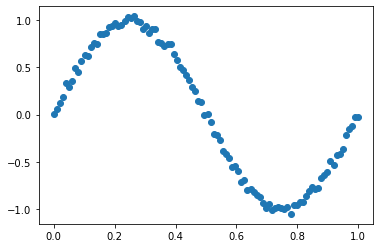

In [25]:
x,t = generateDataset(100, f, 0.03)
plt.scatter(x,t)

In [26]:
import math
import numpy as np
def s(x): return x**2
def f(x): return math.sin(2 * math.pi * x)
vf = np.vectorize(f)        # Create a vectorized version of f

z = np.array([1,2,3,4])
print(z)

sz = s(z)                   # You can apply simple functions to an array
print(sz.shape)             # Same dimension as z (4)
print(sz)

fz = vf(z)                  # For more complex ones, you must use the vectorized version of f
print(fz.shape)
print(fz)

[1 2 3 4]
(4,)
[ 1  4  9 16]
(4,)
[-2.44929360e-16 -4.89858720e-16 -7.34788079e-16 -9.79717439e-16]


<a name="curvefitting"></a>
<h3>2.2 Polynomial Curve Fitting</h3>

We will attempt to learn the function y given a synthetic dataset $(x, t)$.

We assume that $y$ is a polynomial of degree $M$ - that is:

$y(x) = w_0 + w_1 x + w_2 x^2 + ... + w_M x^M$

Our objective is to estimate the vector $w = (w_0 \dots w_M)$ from the dataset $(x, t)$.

In [27]:
import numpy as np
import scipy.linalg

t = np.array([1,2,3,4])                    # This is a vector of dim 4
t.shape                                    # (4,)
phi = np.array([[1,1],[2,4],[3,3],[2,4]])  # This is a 4x2 matrix
phi.shape                                  # (4, 2) 
prod = np.dot(phi.T, phi)                  # prod is a 2x2 matrix
prod.shape                                 # (2, 2)
i = np.linalg.inv(prod)                    # i is a 2x2 matrix
i.shape                                    # (2, 2)
m = np.dot(i, phi.T)                       # m is a 2x4 matrix
m.shape                                    # (2, 4)
w = np.dot(m, t)                           # w is a vector of dim 2
w.shape                                    # (2,)

(2,)

We implement a method <b>optimizeLS(x, t, M)</b> which given the dataset $(x, t)$ returns the optimal polynomial of degree $M$ that approximates the dataset according to the least squares objective. 

In [28]:
def calculate_design_matrix(x, M):
    design_m = np.zeros((len(x), M + 1))
    for i in range(len(x)):
        for j in range(0, M + 1):
            design_m[i][j] = pow(x[i], j)
    return design_m

def optimizeLS(x, t, M):
    design_m = calculate_design_matrix(x, M)
    w = np.dot(design_m.T, design_m)
    w = np.linalg.inv(w)
    w = np.dot(w, design_m.T)
    w = np.dot(w, t)
    return w

We now plot the learned polynomial $w_M(x_i)$ and the real function $sin(2πx)$ for a dataset of size $N=10$ and $M=1,3,5,10$.


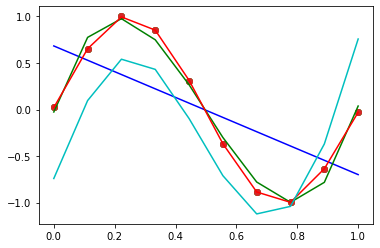

In [29]:
x,t = generateDataset(10, f, 0.03)
M = [1,3,5,10]
colors = ['b', 'g', 'r', 'c']
for i in range(len(M)):
    coeffs = optimizeLS(x,t,M[i])
    plt.scatter(x, t)
    y = np.array([np.sum(np.array([coeffs[i]*(j**i) for i in range(len(coeffs))])) for j in x])
    plt.plot(x, y, color=colors[i])

<a name="regularization"></a>
<h3>2.3 Polynomial Curve Fitting with Regularization</h3>

We observe in the plot above that the solution to the least-squares optimization has a tendency to over-fit the dataset.

To avoid over-fitting, we will use <i>regularization</i>: the objective function we want to optimize will take into account the least-squares error as above, and in addition the complexity of the learned model $w$.

We write a function <b>optimizePLS(x, t, M, lambda)</b> which returns the optimal parameters $w_{PLS}$ given $M$ and $\lambda$.

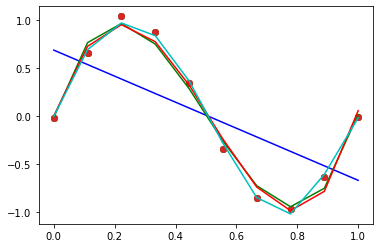

In [30]:
def optimizePLS(x, t, M, lamb):
    design_m = calculate_design_matrix(x, M)
    w = np.dot(design_m.T, design_m)
    w = w + (np.identity(M + 1) * lamb)
    w = np.linalg.inv(w)
    w = np.dot(w, design_m.T)
    w = np.dot(w, t)
    return w

def calculatePointsFromCoef(coeffs, x):
    return np.array([np.sum(np.array([coeffs[i]*(j**i) for i in range(len(coeffs))])) for j in x])

x,t = generateDataset(10, f, 0.03)
M = [1,3,5,10]
colors = ['b', 'g', 'r', 'c']
for i in range(len(M)):
    coeffs = optimizePLS(x,t,M[i], 0.0001)
    plt.scatter(x, t)
    y = calculatePointsFromCoef(coeffs, x)
    plt.plot(x, y, color=colors[i])

We want to optimize the value of λ. The way to optimize is to use a development set in addition to our training set.

To construct a development set, we extend our synthetic dataset construction function to return 3 samples:
* one for training, 
* one for development 
* and one for testing

In [31]:
def generateSet(N, f, sigma, x):
    t = []
    s = np.random.default_rng().normal(0, sigma, N)
    for i in range(0, N):
        t.append(f(x[i]) + s[i])
    return t
    
def generateDataset3(N, f, sigma):
    x = numpy.linspace(0.0, 1.0, 3 * N)
    np.random.default_rng().shuffle(x)
    x_train, x_valid, x_test = np.split(x, 3)
    return (x_train, generateSet(N, f, sigma, x_train)), (x_valid, generateSet(N, f, sigma, x_valid)), (x_test, generateSet(N, f, sigma, x_test))

def calculateMeanError(coeffs, xv, tv):
    estimated_points = calculatePointsFromCoef(coeffs, xv)
    return np.sqrt(np.sum(np.power((tv-estimated_points),2))) / len(xv)

def calculate_mse_for_lambs(xt, tt, xv, tv, xtest, ttest, M):
    train_errors = []
    valid_errors = []
    test_errors = []
    lambs = []
    for i in range(-40, -20):
        lamb = pow(2, i)
        coeffs = optimizePLS(xt, tt, M, lamb)
        lambs.append(lamb)
        train_errors.append(calculateMeanError(coeffs, xt, tt))
        valid_errors.append(calculateMeanError(coeffs, xv, tv))
        test_errors.append(calculateMeanError(coeffs, xtest, ttest))
    return lambs, train_errors, valid_errors, test_errors

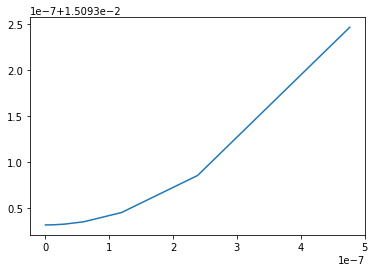

In [32]:
train_set, valid_set, test_set = generateDataset3(10, f, 0.03)
xt, tt = train_set
xv, tv = valid_set
x_test, t_test = test_set
lambs, train_errors, valid_errors, test_errors = calculate_mse_for_lambs(xt, tt, xv, tv, x_test, t_test, 3)
plt.plot(lambs, train_errors)

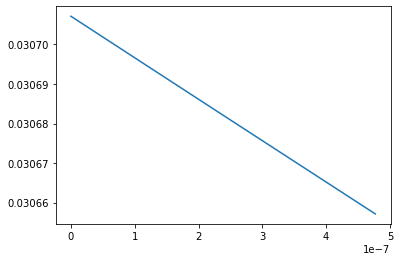

In [33]:
plt.plot(lambs, valid_errors)

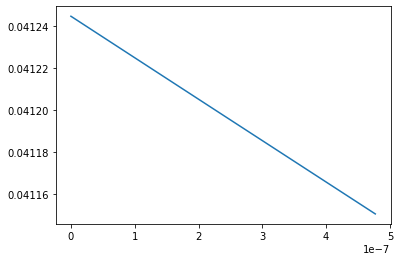

In [34]:
plt.plot(lambs, test_errors)

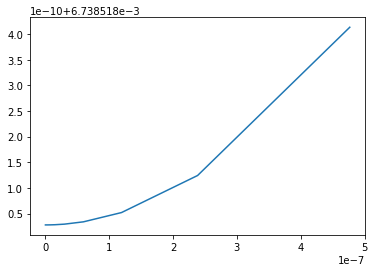

In [35]:
train_set, valid_set, test_set = generateDataset3(100, f, 0.03)
xt, tt = train_set
xv, tv = valid_set
x_test, t_test = test_set
lambs, train_errors, valid_errors, test_errors = calculate_mse_for_lambs(xt, tt, xv, tv, x_test, t_test, 3)
plt.plot(lambs, train_errors)

Given a synthetic dataset, we optimize for the value of λ by varying the value of log(λ) from -40 to -20 on the development set. 

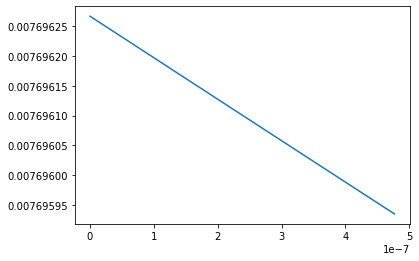

In [36]:
plt.plot(lambs, valid_errors)

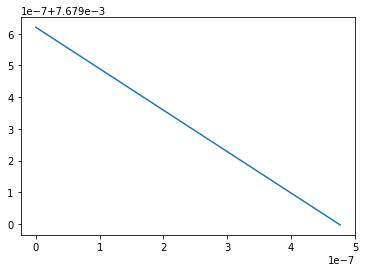

In [37]:
plt.plot(lambs, test_errors)

from the plots above we can cleary see that when the lambda paramter is bigger then the error on the train set gets bigger, but the error on the validation set and the test set is smaller.
we can see that the model can generalized better on data he didn't see before thanks to the regularization which prevents the overfitting of the model.

In [38]:
def optimizePLS2(xt, tt, xv, tv, M):
    best_error = 10000
    best_lamb = 0.0
    for i in range(-40, -20):
        lamb = pow(2, i)
        coeffs = optimizePLS(xt, tt, M, lamb)
        new_error = calculateMeanError(coeffs, xv, tv)
        if new_error < best_error:
            best_error = new_error
            best_lamb = lamb
    return best_lamb

optimizePLS2(train_set[0], train_set[1], valid_set[0], valid_set[1], 3)

4.76837158203125e-07

<a name="prob-regr"></a>
<h3>2.4 Probabilistic Regression Framework</h3>

We now consider the same problem of regression (learning a function from a dataset) formulated in a probabilistic framework.

In [61]:
def Mean(x, sigma2, design_m_train, t_train, M, S):
    design_m = calculate_design_matrix(x, M)
    m = np.matmul(design_m_train.T, t_train)
    m = np.dot(S, m)
    m = np.dot(design_m, m)
    return (1/sigma2) * m.T

def Var(x, sigma2, M, S):
    design_m = calculate_design_matrix(x, M)
    v = np.dot(S, design_m.T)
    v = np.dot(design_m, v)
    return v + sigma2


def calculate_sum_vector(m, t, N):
    return np.sum([np.dot(m[i,:], t[i]) for i in range(0, N)])

def calculate_sum_matrices(m, t, N):
    print(m[i,:])
    print(t[:,i])
    return np.sum([np.dot(m[i,:], t[:,i]) for i in range(0, N)])

def bayesianEstimator(x, t, M, alpha, sigma2):
    t = np.array(t)
    design_m = calculate_design_matrix(x, M)
    s =  np.linalg.inv((np.identity(M + 1) * alpha) + ((1/sigma2) * np.matmul(design_m.T, design_m)))
    m = lambda x: Mean(x, sigma2, design_m, t, M, s)
    v = lambda x: Var(x, sigma2, M, s)
    return m, v

We draw the plot of the original function $y = sin(2πx)$ over the range $[0 \dots 1]$, the mean of the predictive distribution $m(x)$ and the confidence interval $m(x) - \sqrt{var(x)}$ and $m(x) + \sqrt{var(x)}$ (that is, one standard deviation around each predicted point) for the values:
* $\alpha = 0.005$
* $\sigma^2 = 1/11.1$
* $M = 9$

over a synthetic dataset of size $N=10$ and $N=100$.

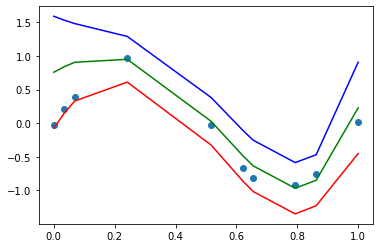

In [62]:
def calculate_point_from_mean_and_variance(M, m, v, x):
    result = []
    for j in x:
        point = m([j])
        var = v([j])
        result.append((point[0], point[0] + np.sqrt(var[0]), point[0] - np.sqrt(var[0])))
    return result


train_set, valid_set, test_set = generateDataset3(10, f, 0.03)
xt, tt = train_set
xv, tv = valid_set
x_test, t_test = test_set
m, v = bayesianEstimator(xt, tt, 9, 0.005, 1/11.1)
sorted_xv = sorted(xv)
y = calculate_point_from_mean_and_variance(9, m, v, sorted_xv)
plt.scatter(xv, tv)
plt.plot(sorted_xv, [point[0] for point in y], color='g')
plt.plot(sorted_xv, [point[1] for point in y], color='b')
plt.plot(sorted_xv, [point[2] for point in y], color='r')

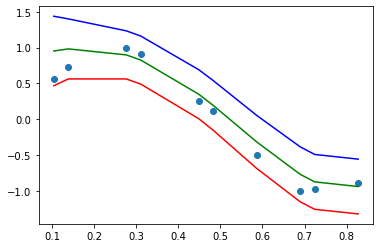

In [63]:
sorted_xtest = sorted(x_test)
y = calculate_point_from_mean_and_variance(9, m, v, sorted_xtest)
plt.scatter(x_test, t_test)
plt.plot(sorted_xtest, [point[0] for point in y], color='g')
plt.plot(sorted_xtest, [point[1] for point in y], color='b')
plt.plot(sorted_xtest, [point[2] for point in y], color='r')

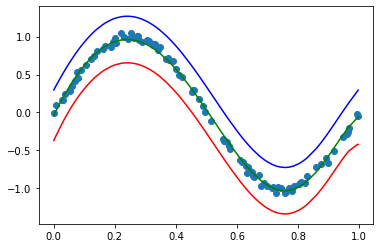

In [64]:
train_set, valid_set, test_set = generateDataset3(100, f, 0.03)
xt, tt = train_set
xv, tv = valid_set
x_test, t_test = test_set
m, v = bayesianEstimator(xt, tt, 9, 0.005, 1/11.1)
sorted_xv = sorted(xv)
y = calculate_point_from_mean_and_variance(9, m, v, sorted_xv)
plt.scatter(xv, tv)
plt.plot(sorted_xv, [point[0] for point in y], color='g')
plt.plot(sorted_xv, [point[1] for point in y], color='b')
plt.plot(sorted_xv, [point[2] for point in y], color='r')

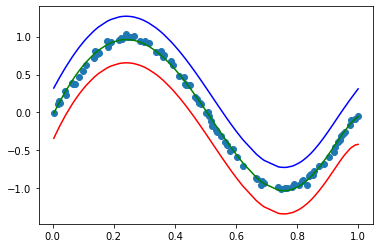

In [65]:
sorted_xtest = sorted(x_test)
y = calculate_point_from_mean_and_variance(9, m, v, sorted_xtest)
plt.scatter(x_test, t_test)
plt.plot(sorted_xtest, [point[0] for point in y], color='g')
plt.plot(sorted_xtest, [point[1] for point in y], color='b')
plt.plot(sorted_xtest, [point[2] for point in y], color='r')

Interpret the height of the band around the most likely function in terms of the distribution of the xs in your synthetic dataset.
Can you think of ways to make this height very small in one segment of the function and large in another?

<hr/>
<hr/>
<a name="P3"></a>
<h2>Part 3: Neural Models for Classification</h2>

In this section, we adopt the PyTorch tutorial on 
<a href="https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html">Character RNN for classification</a>
to a different dataset.

<a name="readtut"></a>
<h3>3.1 Summarize the Tutorial</h3>

We summarize the <a href="https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html">PyTorch tutorial</a>:
* task
* method
* data encoding
* loss function 
* evaluation method

(Reading <a href="https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html">PyTorch Tensor Tutorial</a> helps)

<a name="newdata"></a>
<h3>3.2 Explore City Names Dataset</h3>

We use a dataset on city names in different countries to train a classifier.

The data from <a href="cities_val.zip">cities_val.zip</a> (validation) and <a href="cities_train.zip">cities_train.zip</a> (training)
is under "../data/cities/val" and "../data/cities/train".


In [88]:
import codecs
import math
import random
import string
import time
import numpy as np
from sklearn.metrics import accuracy_score

'''
Don't change these constants for the classification task.
You may use different copies for the sentence generation model.
'''
languages = ["af", "cn", "de", "fi", "fr", "in", "ir", "pk", "za"]
all_letters = string.ascii_lowercase + " .,;'"
n_letters = len(all_letters)
n_categories = len(languages)

import unicodedata

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = languages

# Read a file and split into lines
def readLines(filename):
    lines = codecs.open(filename, "r",encoding='utf-8', errors='ignore').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

Explore the train dataset by computing basic descriptive statistics:
number of categories, tokens per category, number of characters, distinct characters, average number of characters per token.

Explain why the unicodeToAscii is a good idea for this task.

In [89]:
for (dirpath, dirnames, filenames) in os.walk('../data/cities/train'):
    for file in filenames:
        category_lines[file.split('.')[0]] = readLines(os.path.join('../data/cities/train', file))
for x,y in category_lines.items():
    print(x,y[0])

af garavshakh
cn yungming
de rudenweiler
fi navala
fr premery
in tagegin
ir borough of cheshire east
pk angurai
za molazzana


number of categories in the dataset is : 9


<BarContainer object of 9 artists>

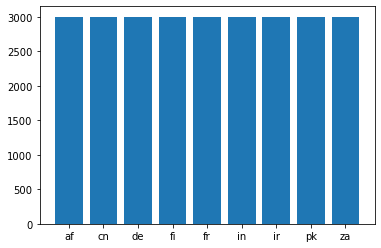

In [90]:
print('number of categories in the dataset is : {}'.format(n_categories))

cities_per_category = {x : len(y) for x,y in category_lines.items()}

plt.bar(cities_per_category.keys(), height=cities_per_category.values())

{'af': 4859, 'cn': 3258, 'de': 5292, 'fi': 4184, 'fr': 3939, 'in': 4343, 'ir': 4933, 'pk': 5741, 'za': 4554}


<BarContainer object of 9 artists>

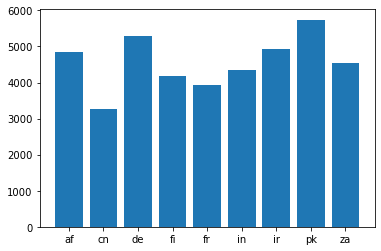

In [108]:
tokens_per_category = {x : np.sum([len(city.split(' ')) for city in y]) for x,y in category_lines.items()}
plt.bar(tokens_per_category.keys(), height=tokens_per_category.values())

<BarContainer object of 9 artists>

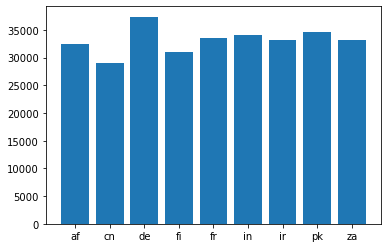

In [91]:
chars_per_category = {x : np.sum([len(city) for city in y]) for x,y in category_lines.items()}
plt.bar(tokens_per_category.keys(), height=tokens_per_category.values())

In [92]:
distinct_chars = set([char for cities in category_lines.values() for city in cities for char in city])
print('we have {} distinct chars in the dataset, we expect that value to be equal or lower to {}'.format(len(distinct_chars), n_letters))

we have 29 distinct chars in the dataset, we expect that value to be equall to 31


<BarContainer object of 9 artists>

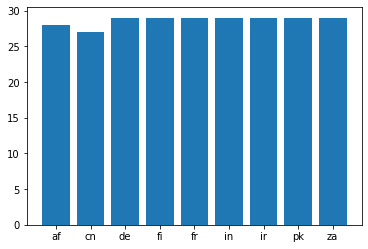

In [124]:
distinct_chars_per_category = {x : len(set([char for city in cities for char in city])) for x, cities in category_lines.items()}
plt.bar(distinct_chars_per_category.keys(), height=distinct_chars_per_category.values())

<BarContainer object of 9 artists>

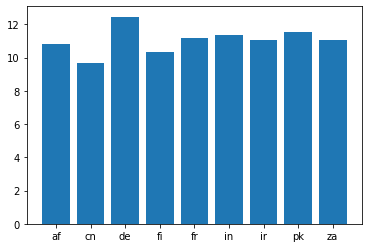

In [125]:
average_chars_per_category = {x : sum(len([char for city in cities for char in city]))/len(cities) for x, cities in category_lines.items()}
plt.bar(average_chars_per_category.keys(), height=average_chars_per_category.values())

we use unicode to ascii in that task because if we just used each languge letter this wont be an hard task, we want the computer to understund the langugue based on the same letter.

<a name="citiesmodel"></a>
<h3>3.3 Train a Model and Evaluate It</h3>

Adopt the code of the PyTorch tutorial to run on this new dataset.

Report on performance in a similar manner.  Explain the main confusion cases observed in the confusion matrix.

In [93]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [94]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [95]:
import random

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = pk / line = kotli nasir
category = za / line = muzalevo
category = de / line = moosbichl
category = fr / line = vendets
category = ir / line = lezzeh
category = pk / line = khojari babar
category = fr / line = fraissinetchazalais
category = in / line = fuzuling
category = fi / line = karvasniemi
category = za / line = lekhalaneng


In [96]:
criterion = nn.NLLLoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), 0.5)

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [101]:
import time
import math

n_iters = 200000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 2% (0m 8s) 0.0919 ampafitatra / fi ✓
10000 5% (0m 16s) 1.1806 obsza / za ✓
15000 7% (0m 25s) 1.3077 dhabbun / pk ✓
20000 10% (0m 33s) 1.4402 stockton springs / fr ✗ (in)
25000 12% (0m 41s) 2.1526 radkila / ir ✗ (fi)
30000 15% (0m 50s) 2.6738 lawanggintung / cn ✗ (in)
35000 17% (0m 58s) 3.0375 finca achihuaypolla / cn ✗ (fi)
40000 20% (1m 7s) 2.8894 taftebole / fi ✗ (af)
45000 22% (1m 15s) 2.3314 bangra / pk ✗ (in)
50000 25% (1m 23s) 0.0015 azadegan / za ✓
55000 27% (1m 32s) 0.0329 la bruffiere / fi ✓
60000 30% (1m 40s) 0.3702 shangcaoshi / cn ✓
65000 32% (1m 49s) 0.5630 quebrada frijoles / fr ✓
70000 35% (1m 57s) 0.1798 los finitos / fi ✓
75000 37% (2m 6s) 2.4177 schweiditz / in ✗ (de)
80000 40% (2m 14s) 0.1011 jialing zhen / cn ✓
85000 42% (2m 23s) 0.8115 hudu / cn ✓
90000 45% (2m 31s) 0.3475 trubkildino / in ✓
95000 47% (2m 39s) 0.7729 abdul firuz / fi ✓
100000 50% (2m 48s) 0.8975 frederiksbjaerg / fi ✗ (fr)
105000 52% (2m 56s) 0.3929 lundenberg / de ✓
110000 55% (3m 5s) 0.2492 

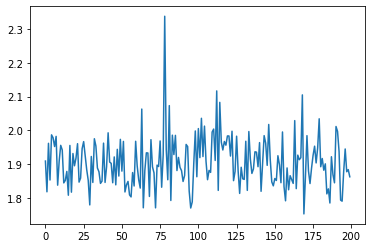

In [103]:
plt.figure()
plt.plot(all_losses)

<ipython-input-104-f984d1a39c33>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-104-f984d1a39c33>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


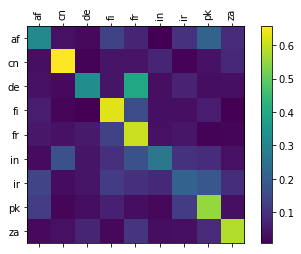

In [104]:
import matplotlib.ticker as ticker

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

<a name="bettercitiesmodel"></a>
<h3>3.4 Improve the RNN Model (Optional)</h3>

Explore methods to improve performance of the cities classifier.
Use a character RNN, dropout, better initialization.

Report on error reduction.